# Add new data

## **Prepare Environment**

<br/>

### Imports

In [1]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# deep learning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Other
from IPython.display import Image
from time import time
import configparser
import subprocess
import warnings
import pprint
import os

# custom functions
import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path

from utils import (
    path_to_work,
    plot_box_plot,
    save_image,
    save_dataframe,
    test_stationary,
    show_result_model,
)

2024-05-05 04:00:39.466626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Prepare Principal Directory

In [2]:
path_to_work('notebooks')

'Changed directory to: /Users/bruno.campos/projects/forecast-of-time-series-with-stock-data/notebooks'

<br/>

### Set Config

In [3]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True,
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

In [4]:
# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

plt.style.use('fivethirtyeight')

<br/>

### Load Data

In [5]:
%%time
df = pd.read_csv('data/raw/ibov_04-2024.csv', encoding='utf8', delimiter=',', parse_dates=True, index_col=0, verbose=True)
print(df.info())
df.head()

Tokenization took: 1.06 ms
Type conversion took: 1.03 ms
Parser memory cleanup took: 0.00 ms
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1571 entries, 2018-01-02 16:56:00 to 2024-05-03 16:56:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1571 non-null   float64
 1   close   1571 non-null   float64
 2   high    1571 non-null   float64
 3   low     1571 non-null   float64
dtypes: float64(4)
memory usage: 61.4 KB
None
CPU times: user 20.5 ms, sys: 3.48 ms, total: 24 ms
Wall time: 24.7 ms


,open,close,high,low
date,,,,
2018-01-02 16:56:00,76402.60,77891.04,77909.01,76402.60
2018-01-03 16:56:00,77889.41,77995.16,78413.89,77601.52
2018-01-04 16:56:00,77997.69,78647.42,79134.83,77997.69
2018-01-05 16:56:00,78644.27,79071.47,79071.47,78218.11
2018-01-08 16:56:00,79070.27,79378.54,79395.45,78631.25


## Split Data

In [6]:
size_train = round(1571*0.7)
size_test = round(1571*0.3)
df_train = df.iloc[:size_train]
df_test = df.iloc[size_train:]

print(f'Total training = {size_train}')
print(f'Total testing = {size_test}')

Total training = 1100
Total testing = 471


Text(0.5, 1.0, 'Train size: 1100')

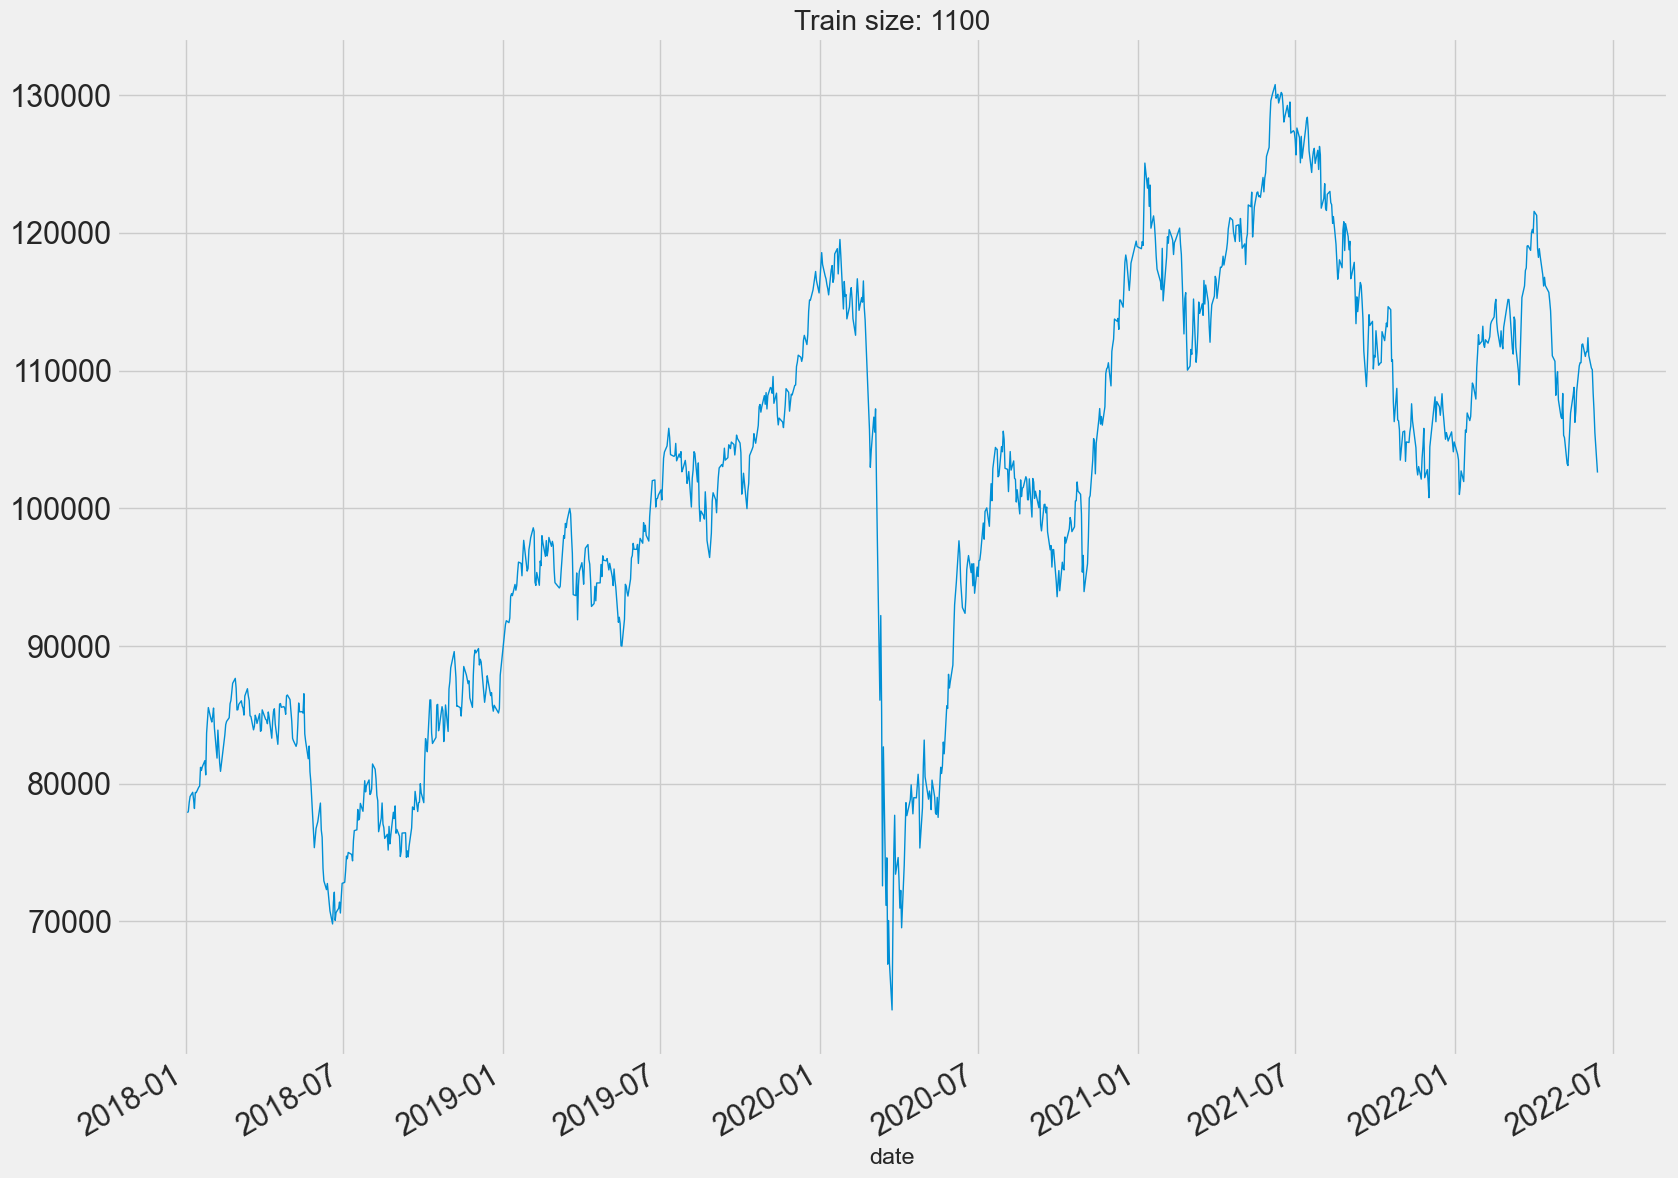

In [7]:
df_train['close'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(df_train)}')

Text(0.5, 1.0, 'Test size: 471')

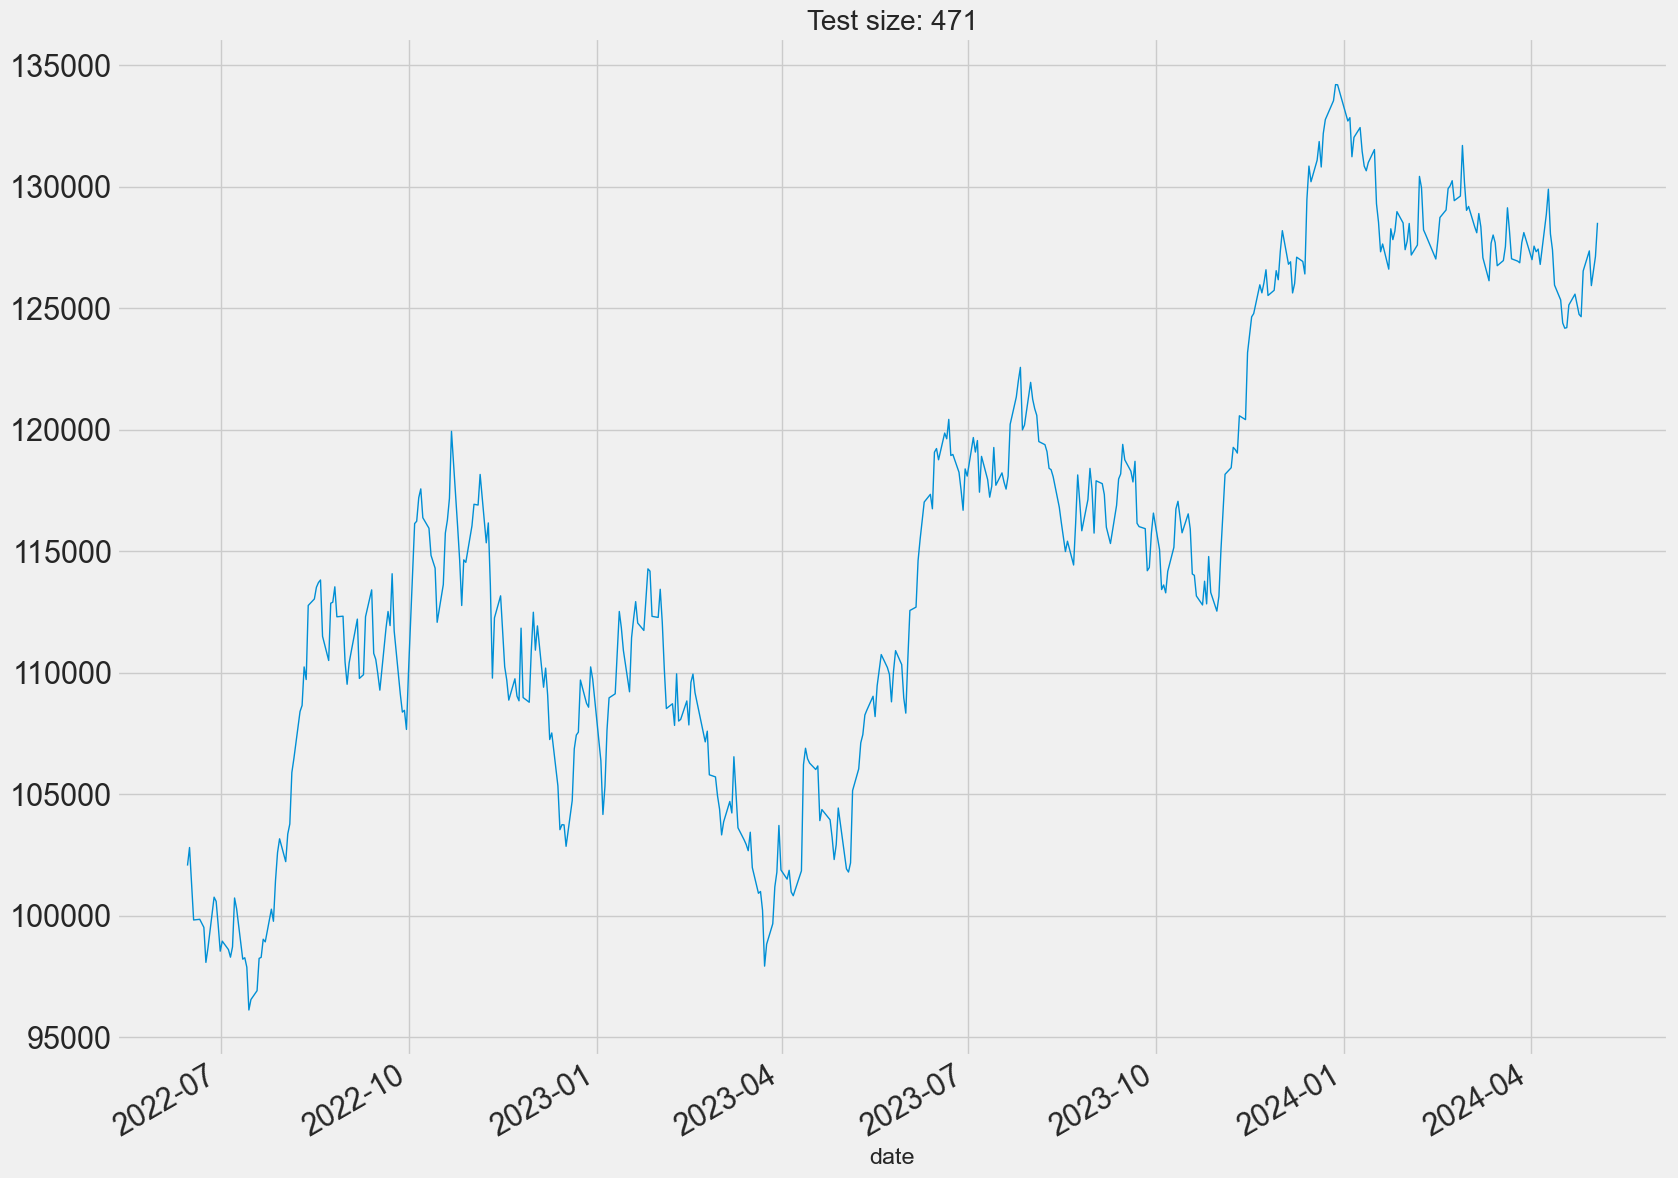

In [8]:
df_test['close'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(df_test)}')

In [9]:
df_train.index

DatetimeIndex(['2018-01-02 16:56:00', '2018-01-03 16:56:00',
               '2018-01-04 16:56:00', '2018-01-05 16:56:00',
               '2018-01-08 16:56:00', '2018-01-09 16:56:00',
               '2018-01-10 16:56:00', '2018-01-11 16:56:00',
               '2018-01-12 16:56:00', '2018-01-15 16:56:00',
               ...
               '2022-05-31 16:56:00', '2022-06-01 16:56:00',
               '2022-06-02 16:56:00', '2022-06-03 16:56:00',
               '2022-06-06 16:56:00', '2022-06-07 16:56:00',
               '2022-06-08 16:56:00', '2022-06-09 16:56:00',
               '2022-06-10 16:56:00', '2022-06-13 16:56:00'],
              dtype='datetime64[ns]', name='date', length=1100, freq=None)

In [10]:
df_test.index

DatetimeIndex(['2022-06-14 16:56:00', '2022-06-15 16:56:00',
               '2022-06-17 16:56:00', '2022-06-20 16:56:00',
               '2022-06-21 16:56:00', '2022-06-22 16:56:00',
               '2022-06-23 16:56:00', '2022-06-24 16:56:00',
               '2022-06-27 16:56:00', '2022-06-28 16:56:00',
               ...
               '2024-04-19 16:56:00', '2024-04-22 16:56:00',
               '2024-04-23 16:56:00', '2024-04-24 16:56:00',
               '2024-04-25 16:56:00', '2024-04-26 16:56:00',
               '2024-04-29 16:56:00', '2024-04-30 16:56:00',
               '2024-05-02 16:56:00', '2024-05-03 16:56:00'],
              dtype='datetime64[ns]', name='date', length=471, freq=None)

## Modeling

In [11]:
train_max = df_train.max()
train_min = df_train.min()

train = (df_train - train_min)/(train_max - train_min)
test = (df_test - train_min)/(train_max - train_min)

In [12]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs).astype('float32'), np.array(ys).astype('float32')

In [13]:
time_steps = 1

X_train, y_train = create_dataset(train, train['close'], time_steps)
X_test, y_test = create_dataset(test, test['close'], time_steps)

### Build Model

#### LSTM
- reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [14]:
# sequential model
model_lstm = Sequential(name='ibov')
model_lstm

<Sequential name=ibov, built=False>

#### Input Layer

In [15]:
#Adding the first LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=len(df_train.columns),
                    return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))

#### Hidden Layers

In [16]:
# Adding a second LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10))
model_lstm.add(Dropout(0.2))

In [17]:
model_lstm.add(Dense(units=1))

In [18]:
model_lstm.compile(loss='mean_squared_error',
                   optimizer='adam',
                   metrics=['mse', 'mape'])

In [19]:
model_lstm.summary()

Model: "ibov"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 10)          │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435 (9.51 KB)

 Trainable params: 2,435 (9.51 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [20]:
%%time
history = model_lstm.fit(X_train,
                         y_train,
                         epochs=1000,
                         batch_size=5,
                         shuffle=False,
                         validation_split=0.30,
                         verbose=0)
history

CPU times: user 11min 1s, sys: 1min 52s, total: 12min 54s
Wall time: 8min 55s


In [21]:
print(history.history.keys())

dict_keys(['loss', 'mape', 'mse', 'val_loss', 'val_mape', 'val_mse'])


In [22]:
best_epochs = history.history["loss"].index(min(history.history["loss"]))
best_epochs

911

In [23]:
min(history.history["loss"])

0.0029862092342227697

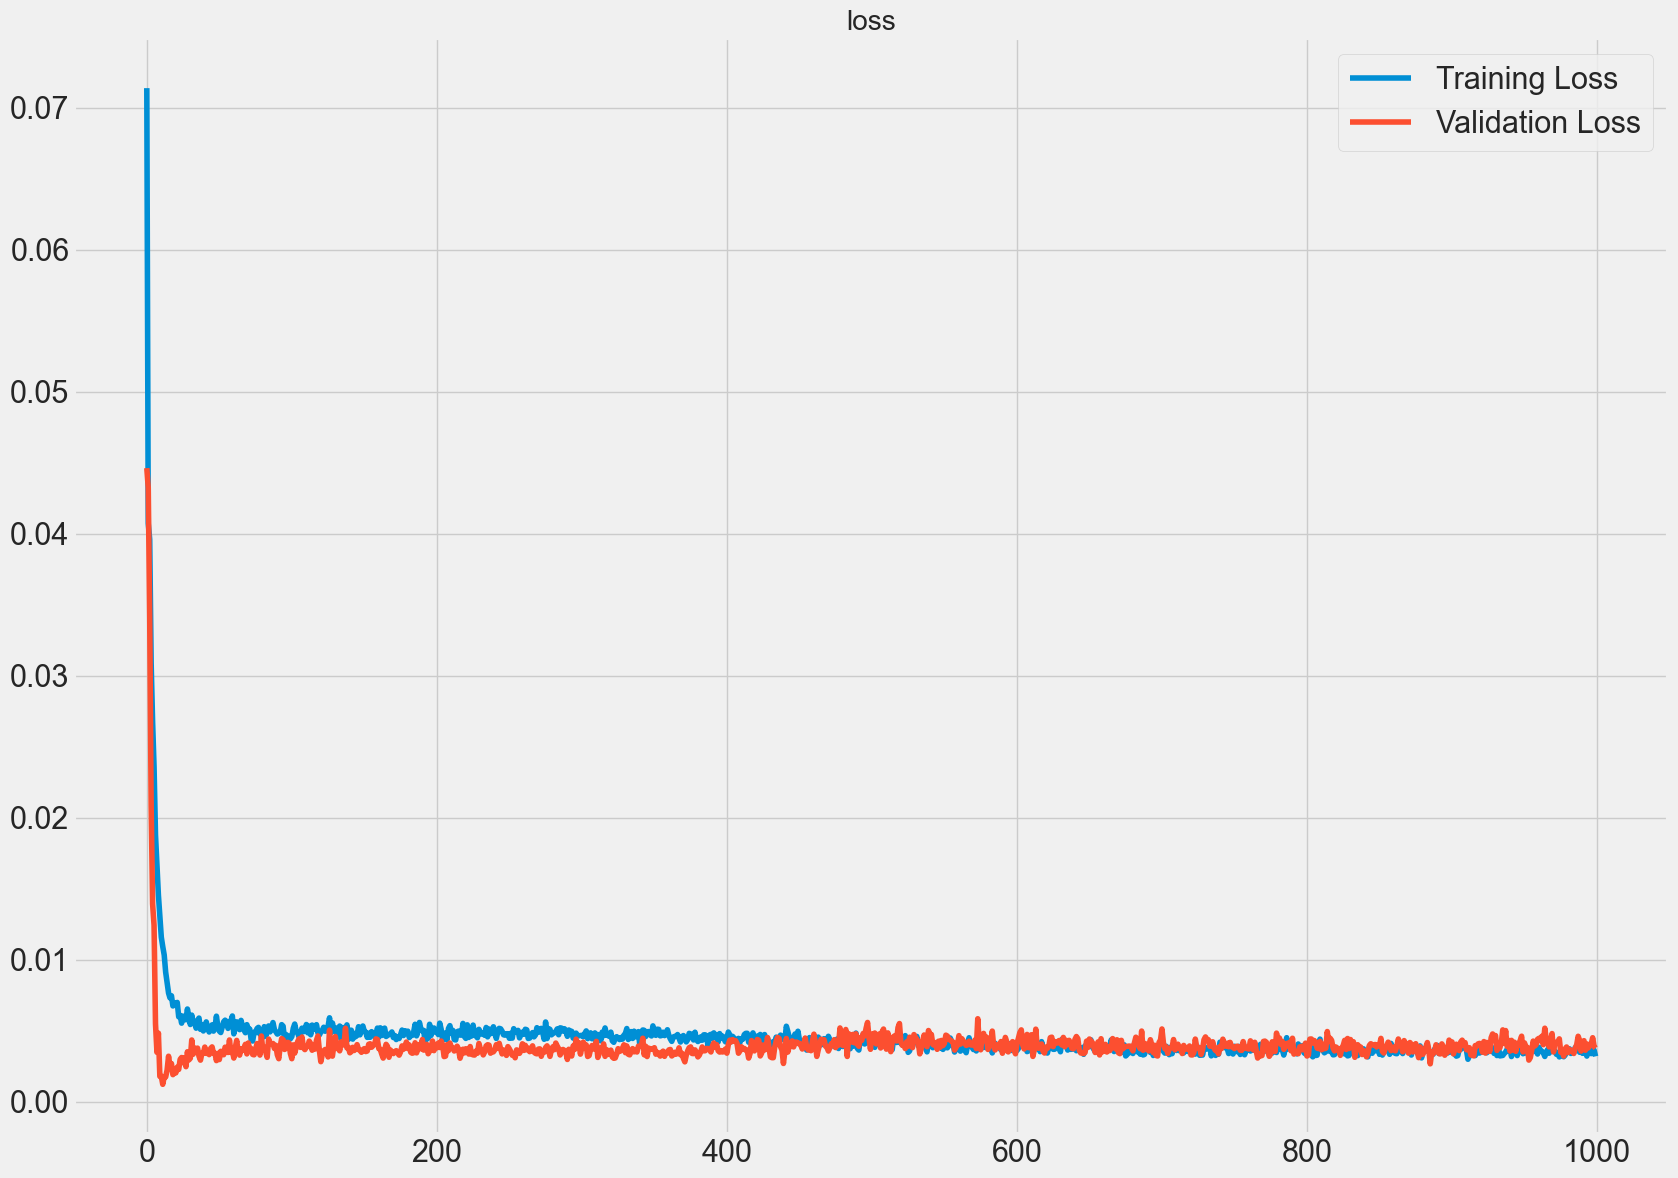

In [24]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('loss')
plt.legend()
plt.show()

---

### Predicts

In [25]:
y_pred = model_lstm.predict(X_test)
print(type(y_pred))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
<class 'numpy.ndarray'>


In [26]:
# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

In [27]:
y_test[:10]
y_train[:10]
print(len(y_train))
print(len(y_test))

1099
470


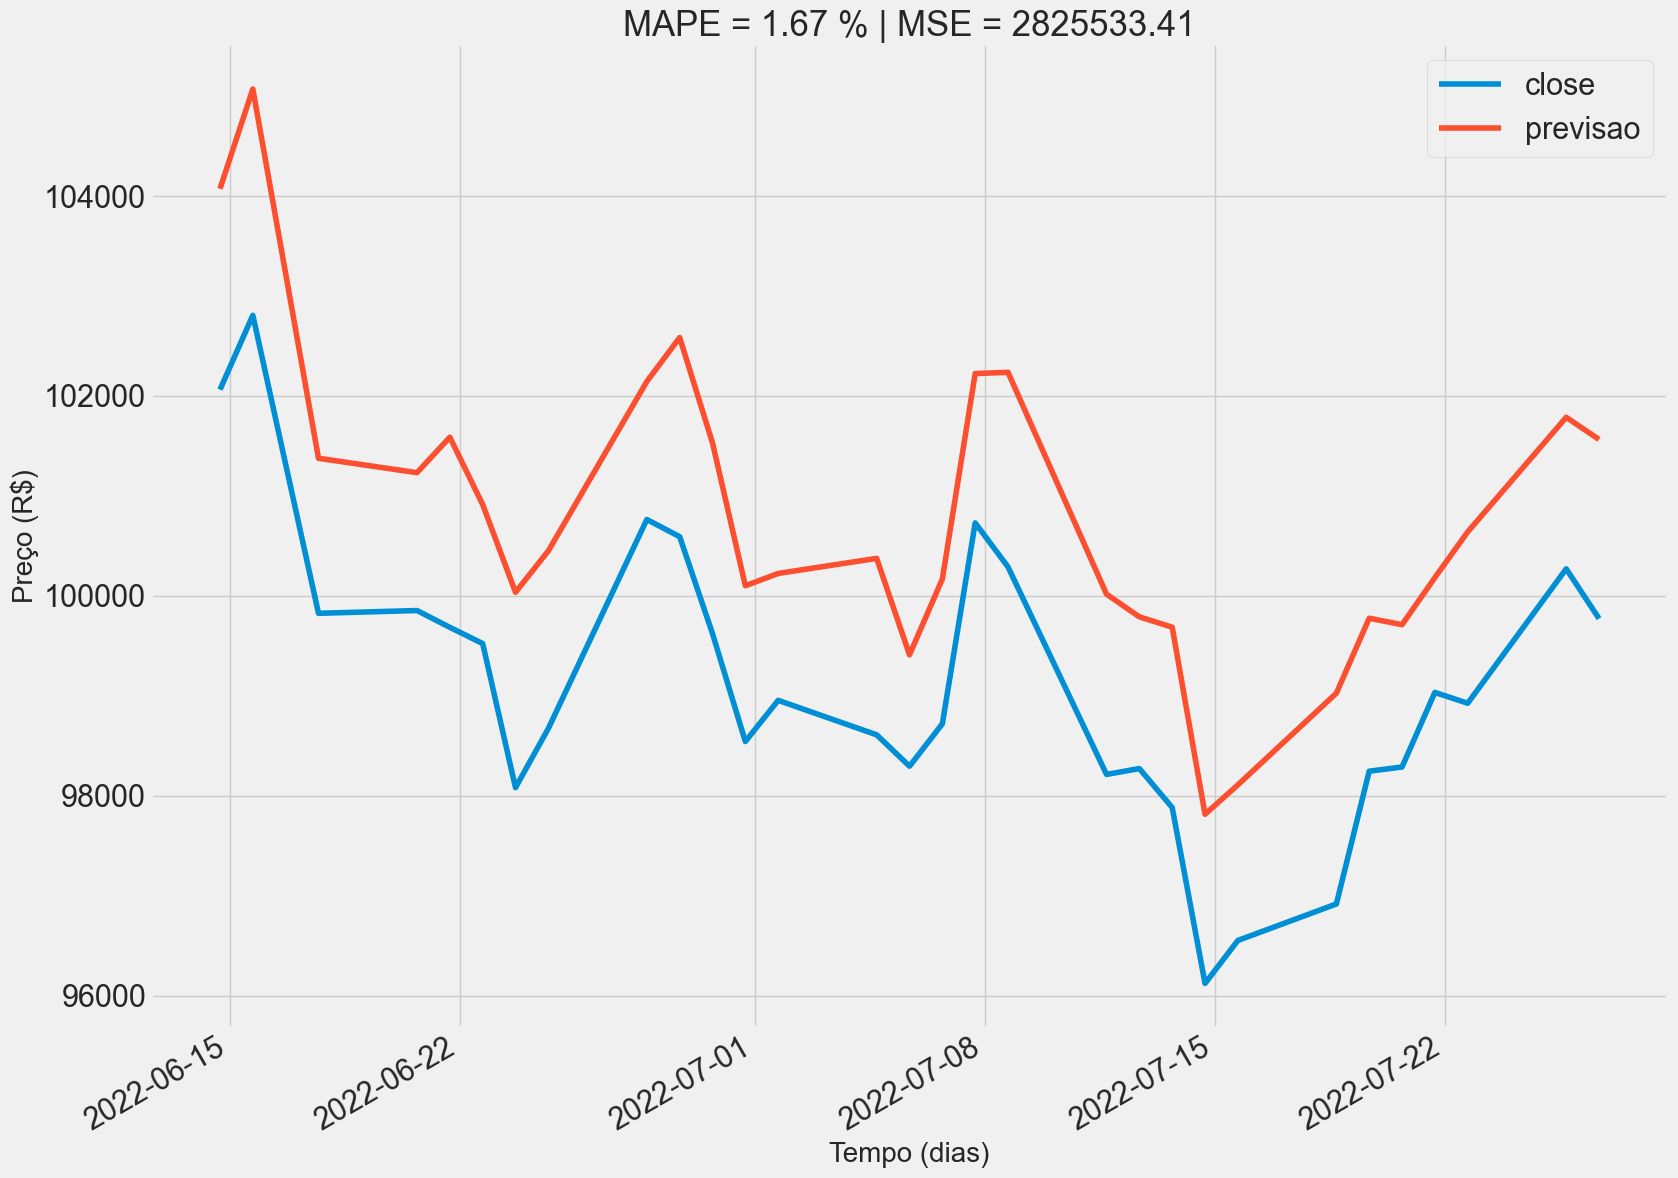

In [34]:
dict_results = {}
df = show_result_model(
    df_test=df_test['close'][:30],
    y_forecast=y_pred[:30],
    model_name='model_lstm',
    dict_results=dict_results,
)

In [36]:
data = {'test': df_test['close'][:470], 'predict': y_pred.flatten() + 5200}
df = pd.DataFrame(data)
df['diff_points'] = df['test'] - df['predict']
df['diff_point_%'] = round((df['diff_points'] / df['test']) * 100, 2)
df.tail()

,test,predict,diff_points,diff_point_%
date,,,,
2024-04-25 16:56:00,124645.58,124612.78,32.80,0.03
2024-04-26 16:56:00,126526.27,124695.84,1830.43,1.45
2024-04-29 16:56:00,127351.79,124729.77,2622.02,2.06
2024-04-30 16:56:00,125924.19,124708.44,1215.75,0.97
2024-05-02 16:56:00,127122.25,124725.72,2396.53,1.89


---
